In [2]:
import os
import pathlib
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gemmi
import seaborn as sns

In [3]:
# Training set.
train_list = pd.read_csv("/Users/mingbin/Desktop/Wankowicz_lab_Mac/Projects/water/data/train_split.txt", header=None)
train_list = train_list[0].tolist()
# Test set.
test_list = pd.read_csv("/Users/mingbin/Desktop/Wankowicz_lab_Mac/Projects/water/data/test_split.txt", header=None)
test_list = test_list[0].tolist()

## Loop through all pdb files.
pdb_path = pathlib.Path('/Users/mingbin/Desktop/Wankowicz_lab_Mac/Projects/water/data/pdb_redo_data')
pdbs = list(pdb_path.glob('*_final.pdb')) # Pay attention to the pattern of names. A general "*.pdb" would result in duplicate files when looping.
# Train.
pdb_train = []
for a in pdbs:
    name = a.stem.split('_')[0]
    if name in train_list:
        pdb_train.append(a)
# Test.
pdb_test = []
for a in pdbs:
    name = a.stem.split('_')[0]
    if name in test_list:
        pdb_test.append(a)

In [5]:
# Create a dictionary of chains and the list of mols of interest for BOTH training and test sets.
data1, data2 = pdb_train, pdb_test
filter = ['HOH', 'WAT', 'H2O'] # List of crystallographic ligands.

keys=['name', 'structure']
chain_keys=['seq_id', 'res', 'b_fac', 'occ', 'altloc']
wat_train_dict, wat_test_dict = {k: [] for k in keys}, {k: [] for k in keys}
for all_dict, data in zip([wat_train_dict, wat_test_dict], [data1, data2]):
    for a in data: # Loop over all PDB structures.
        name = a.stem.split('_')[0]
        structure = gemmi.read_structure(str(a))
        # Check model.
        i = 0
        model = structure[i]  # consider the first model (skip if empty)
        while len(model) == 0:  # sometimes the first model is empty
            i += 1
            try:
                model = structure[i]
            except Exception:
                raise ValueError("Can't read valid model from the input PDB file!")
        # Chain.
        chain_dict={}
        for chain in model:
            ind_chain={k: [] for k in chain_keys} # seq_id, res, b_fac
            res_list=[]
            id_list=[]
            b_fac=[]
            occ=[]
            altloc=[]
            for res in chain:
                if res.name in filter: # Check if it is not in any of the filter lists.
                    res_list.append(res.name)
                    id_list.append(str(res.seqid))
                    b_fac.append(res[0].b_iso) # Only one atom in water residue: O atom.
                    occ.append(res[0].occ)
                    altloc.append(res[0].has_altloc())
            ind_chain['seq_id']=id_list
            ind_chain['res']=res_list
            ind_chain['b_fac']=b_fac
            ind_chain['occ']=occ
            ind_chain['altloc']=altloc
            # For each chain.
            chain_dict[chain.name] = ind_chain
        # Summarize as {chain: list of mols of interest}.
        all_dict['name'].append(name)
        all_dict['structure'].append(chain_dict)

In [6]:
df_wat_train_altloc=pd.DataFrame(wat_train_dict)
df_wat_test_altloc =pd.DataFrame(wat_test_dict)

In [10]:
df_wat_test_altloc

,name,structure,altloc
0,6zw2,"{'A': {'seq_id': ['501', '502', '503', '504', ...","[[False, False, False, False, False, False, Tr..."
1,4hr3,"{'A': {'seq_id': ['601', '602', '603', '604', ...","[[False, False, False, False, False, False, Fa..."
2,6yp2,"{'A': {'seq_id': ['401', '402', '403', '404', ...","[[False, False, False, False, False, False, Fa..."
3,5pbi,"{'A': {'seq_id': ['2102', '2103', '2105', '210...","[[False, False, False, False, False, False, Fa..."
4,7f5c,"{'A': {'seq_id': ['301', '304', '305', '307', ...","[[False, False, False, False, False, False, Fa..."
...,...,...,...
1288,3vha,"{'A': {'seq_id': ['2', '3', '4', '5', '6', '7'...","[[False, False, False, False, False, False, Fa..."
1289,4xua,"{'A': {'seq_id': ['2101', '2103', '2104', '210...","[[False, False, False, False, False, False, Fa..."
1290,7o5s,"{'A': {'seq_id': ['401', '403', '404', '405', ...","[[False, False, False, False, False, False, Fa..."
1291,6agy,"{'A': {'seq_id': ['201', '202', '203', '204', ...","[[False, False, False, False, False, False, Fa..."


In [8]:
def nested_wat_value(structure_dict, key='altloc'):
    """
    Return all values of interest stored in the chain dictionary. For example, when key is 'altloc', returns the list of all occupancy values of water.
    """
    pdb_value = []
    for k, v in structure_dict.items(): # k is the chain name. v is the individual chain dictionary, with keys: seq_id, res, b_fac, occ.
        value = v[key]
        pdb_value.append(value)
    return pdb_value

In [9]:
# Apply the function to each row of the dataframe.
for df in [df_wat_train_altloc, df_wat_test_altloc]:
    df['altloc'] = None
    df['altloc'] = df['structure'].apply(nested_wat_value)

In [15]:
# Count the number of particular elements, like 'True' and 'False'.
flat.count(True), flat.count(False)

(36533, 1453449)

Training:  1489982
Test:  412396


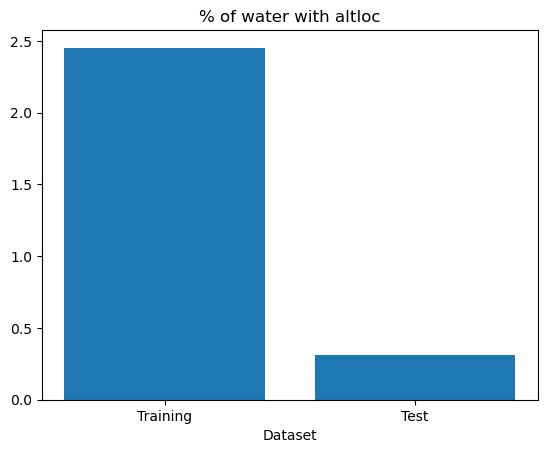

In [18]:
# Plot. Comparison of both set.
nested = df_wat_train_altloc['altloc'].values
flat=[water for structure in nested for chain in structure for water in chain]
print('Training: ', len(flat))

nested2 = df_wat_test_altloc['altloc'].values
flat2=[water for structure in nested2 for chain in structure for water in chain]
print('Test: ', len(flat2))

per_true_train = flat.count(True) / (flat.count(True) + flat.count(False)) * 100
per_true_test = flat2.count(True) / (flat2.count(True) + flat2.count(False)) * 100

plt.bar(['Training', 'Test'], [per_true_train, per_true_test])
plt.xlabel("Dataset")
# plt.ylabel("Number of molecules")
plt.title(r"% of water with altloc")
plt.savefig("figures/7_water_altloc_Both.png", dpi=200)
plt.show()